In this exercise I solve a deterministic growth model using simulated data generated from an economy with parameters $\beta = 0.95$, $\alpha = 0.3$, $A = 1.0$, $\delta = 0.05$, $\gamma = 2.0$. I initiate the variables of the mathematical program at the true values, which should make the optimization easy.

  likely near In[1]:2
  likely near In[1]:2



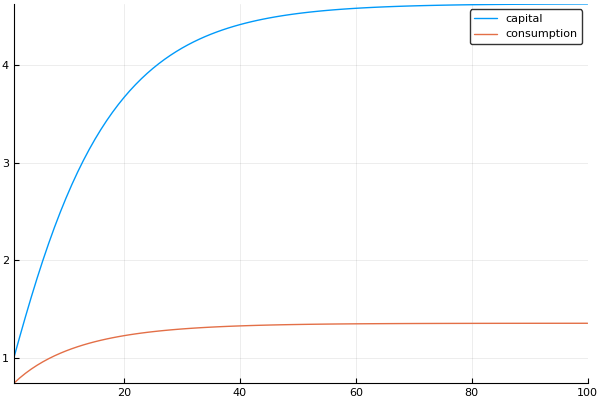

In [1]:
using CSV
using Plots; pyplot()

df = CSV.read("data.csv"; header=false, types=[Float64, Float64])
dataK = convert(Vector{Float64}, df[1])
dataC = convert(Vector{Float64}, df[2])

plot(dataK, label="capital")
plot!(dataC, label="consumption")

The economy's steady state for capital is:

In [2]:
k_stst = 4.628988089138438;

# The Mathematical Program
I define the needed function related to utility and production:

In [3]:
u_crra_prime(c, γ) = begin
    return c^-γ
end

u_crra(c, γ) = begin
    return c^(1-γ) / (1-γ)
end

u_crra_prime_inv(u, γ) = begin
    return u^(-1/γ) 
end

function f(k, α, A)
    A*k^α
end

function f_prime(k, α, A)
    A*α*k^(α-1)
end

f_prime (generic function with 1 method)

In [4]:
u_crra_prime(c, γ) = begin
    if (c <= 0)
        return -100.
        else
        return c^-γ
    end
end

u_crra_prime_inv(u, γ) = begin
    if (u <= 0)
        return +100.
    else
        return u^(-1/γ) 
    end
end

function f(k, α, A)
    if (k <= 0)
        return zero(k)
    else
        A*k^α
    end
end

function f_prime(k, α, A)
    if (k <= 0)
        return zero(k)
    else
        A*α*k^(α-1)
    end
end

f_prime (generic function with 1 method)

I use the Julia Mathematical Programming languange JuMP and the IpOpt solver:

In [5]:
using JuMP
using Ipopt

#m = Model(solver=IpoptSolver(print_level=5, max_iter=500, mu_strategy="adaptive", mu_oracle="probing"));
#m = Model(solver=IpoptSolver(print_level=5, max_iter=500, mu_strategy="adaptive", mu_oracle="probing", corrector_type="affine"));
m = Model(solver=IpoptSolver(print_level=5, max_iter=600));

I define the deep parameters variables and give the the correct starting values:

In [6]:
@variable(m, 0 <= β <= 1, start = 0.95)
@variable(m, 0 <= δ <= 1, start = 0.05)
@variable(m, 0 <= α <= 1, start = 0.3)
@variable(m, A >= 0, start = 1)
@variable(m, 100 >= γ >= 1, start = 2);

The policy function is approximated by 10 Chebyshev polynomials on a grid around the steady state for capital, the coefficients on the polynomials are $\theta$:

I define a grid on capital, $K$, with 10 nodes, and evaluate the Chebyshev polynomials at those point into $\Psi$ and at the observed data points into $\Phi$:

In [7]:
using BasisMatrices
global const params = SplineParams(linspace(0.2*k_stst, 2*k_stst, 10), 0, 3)
basis = Basis(params)
K = nodes(basis)[1] #grid
Ψ = BasisMatrix(basis, Expanded(), K).vals[1]
Ψprime = BasisMatrix(basis, Expanded(), K, 1).vals[1]
Ψprimeprime = BasisMatrix(basis, Expanded(), K, 2).vals[1]
#Ψprimeprimeprime = BasisMatrix(basis, Expanded(), K, 3).vals[1]
Φ = BasisMatrix(basis, Expanded(), dataK).vals[1]
Φprime = BasisMatrix(basis, Expanded(), dataK, 1).vals[1];

In [8]:
@variable(m, θ[1:length(K)], start = 0);

And I initialize $\theta$ such that the consumer myopically consumes almost everything available, leaving just $0.5$ capital for the next period:

In [9]:
initial_θ = Ψ \ (u_crra.((f.(K, getvalue(α), getvalue(A)) + (1-getvalue(δ))*K - 1.), getvalue(γ)) .* 
    (f_prime(1, getvalue(α), getvalue(A)) + 1-getvalue(δ)))
#b2 = Basis(ChebParams(10, 0.2*k_stst, 2*k_stst))
#K2 = nodes(b2)[1] #grid
#Ψ2 = BasisMatrix(basis, Expanded(), K2).vals[1]
#θ2 = Ψ2 \ [0.731039, 0.830067, 0.984055, 1.15697 , 1.32812 , 1.48555 , 1.62093 , 1.72778 , 1.80161 , 1.8393]

#BasisMatrix(basis, Expanded(), K).vals[1] * θ2
#initial_θ = Ψ \ u_crra.(, getvalue(γ)
##stop


for i in 1:length(K)
    setvalue(θ[i], initial_θ[i])
end

In the equilibrium constraint the polynomials have to be evaluated also outside the grid, I define this function here:

In [10]:
function interpVprime(x, values...) #x is the point of evaluation, values are on the grid
    return (evalbase(params, [x], 1) * collect(values))[1] #evaluates the first derivative of the basis functions
end

interpVprime (generic function with 1 method)

I register all user-defined functions with JuMP for automatic differentiation:

In [11]:
JuMP.register(m, :interpVprime, 1+length(K), interpVprime, autodiff=true)
JuMP.register(m, :u_crra_prime, 2, u_crra_prime, autodiff=true)
JuMP.register(m, :f, 3, f, autodiff=true)
JuMP.register(m, :f_prime, 3, f_prime, autodiff=true)
JuMP.register(m, :u_crra_prime_inv, 2, u_crra_prime_inv, autodiff=true)

The auxiliary and equilibrium constraints are all defined on the grid with 10 nodes:

In [12]:
@variable(m, modelC[i=1:length(K)] >= 0, start = 1)
@variable(m, modelKprime[i=1:length(K)] >= 0, start = 1)
@variable(m, modelCprime[i=1:length(K)] >= 0, start = 1)

for i in 1:length(K)
    setvalue(modelC[i], u_crra_prime_inv(
            (Ψprime[i, :]' * getvalue(θ))/(f_prime(K[i], getvalue(α), getvalue(A)) + 1-getvalue(δ)), getvalue(γ)))
    setvalue(modelKprime[i], f(K[i], getvalue(α), getvalue(A)) + (1-getvalue(δ))*K[i] - getvalue(modelC[i]))
    setvalue(modelCprime[i], u_crra_prime_inv(interpVprime(
            getvalue(modelKprime[i]), getvalue(θ)...)/(f_prime(getvalue(modelKprime[i]), getvalue(α), getvalue(A)) + 1-getvalue(δ)), 
            getvalue(γ)))
end

In [13]:
##EE in consumption:
@NLconstraint(m, cons_today[i=1:length(K)], modelC[i] == u_crra_prime_inv(sum(Ψprime[i, k] * θ[k] for k in 1:length(K)) / 
            (f_prime(modelKprime[i], α, A) + 1-δ), γ))
@NLconstraint(m, capi_tomor[i=1:length(K)], modelKprime[i] == f(K[i], α, A) + (1-δ)*K[i] - modelC[i])
@NLconstraint(m, cons_tomor[i=1:length(K)], modelCprime[i] == u_crra_prime_inv(interpVprime(modelKprime[i], 
            θ[1], θ[2], θ[3], θ[4], θ[5], θ[6], θ[7], θ[8], θ[9], θ[10], θ[11], θ[12]) / 
            (f_prime(modelKprime[i], α, A) + 1-δ), γ))

@NLconstraint(m, increasing[i=1:length(K)], sum(Ψprime[i, k] * θ[k] for k in 1:length(K)) >= 0)
@NLconstraint(m, concave[i=1:length(K)], sum(Ψprimeprime[i, k] * θ[k] for k in 1:length(K)) <= 0)
#@NLconstraint(m, convex[i=1:length(K)], sum(Ψprimeprimeprime[i, k] * θ[k] for k in 1:length(K)) >= 0)

@NLconstraint(m, EE[i=1:length(K)], u_crra_prime(modelC[i], γ) == 
    β * u_crra_prime(modelCprime[i], γ) * (f_prime(modelKprime[i], α, A) + 1-δ));

In [14]:
u_crra_prime_inv.(u_crra_prime.(getvalue(modelCprime), getvalue(γ)) .* (f_prime.(getvalue(modelKprime), getvalue(α), getvalue(A)) + 1-getvalue(δ)), getvalue(γ)) .- getvalue(modelC)

12-element Array{Float64,1}:
 -0.0179402
 -0.149752 
 -1.00465  
 -1.5037   
 -2.51405  
 -3.08405  
 -3.88349  
 -4.55795  
 -5.31418  
 -6.09023  
 -6.60798  
 -6.8609   

In [15]:
getvalue(modelC)

12-element Array{Float64,1}:
 0.818921
 1.06131 
 1.85655 
 2.62193 
 3.62771 
 4.43365 
 5.33396 
 6.17516 
 7.03204 
 7.87515 
 8.43679 
 8.71419 

I define auxiliary expressions for the predictions of the equilibrium conditions:

In [16]:
@NLexpression(m, predictedK[t=2:100], f(dataK[t-1], α, A) + (1-δ)*dataK[t-1] - dataC[t-1])
@NLexpression(m, predictedC[t=1:100], u_crra_prime_inv(sum(Φprime[t, k] * θ[k] for k in 1:length(K)), γ));

The objective is to minimize the sum of squared errors:

In [17]:
@NLobjective(m, Min, sum((dataC[t] - predictedC[t])^2 for t in 1:100) +
    sum((dataK[t] - predictedK[t])^2 for t in 2:100))

In [18]:
solve(m)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      588
Number of nonzeros in inequality constraint Jacobian.:      288
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       53
                     variables with only lower bounds:       37
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equa

:Optimal

In [19]:
getvalue(β), getvalue(δ), getvalue(α), getvalue(A), getvalue(γ)

(0.7047353466348902, 1.1300332658834125e-8, 0.954945647102082, 0.3301329391862525, 1.0224618076976537)


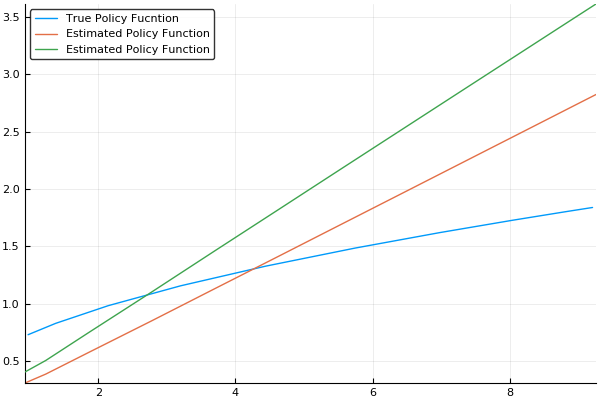

In [20]:
plot(nodes(Basis(ChebParams(10, 0.2*k_stst, 2*k_stst)))[1], [0.731039, 0.830067, 0.984055, 1.15697 , 1.32812 , 1.48555 , 1.62093 , 1.72778 , 1.80161 , 1.8393], label="True Policy Fucntion")
plot!(K, u_crra_prime_inv.(Ψprime * getvalue(θ), getvalue(γ)), label="Estimated Policy Function")
plot!(K, getvalue(modelC), label="Estimated Policy Function")


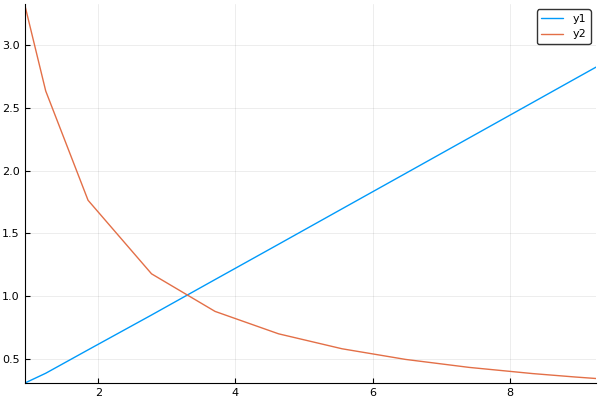

In [21]:
plot(K, u_crra_prime_inv.(Ψprime * getvalue(θ), getvalue(γ)))
plot!(K, Ψprime * getvalue(θ))

In [22]:
sum(u_crra_prime_inv.(Φprime * getvalue(θ), getvalue(γ)) .< 0)

0

In [23]:
Ψprime * getvalue(θ)

12-element Array{Float64,1}:
 3.3263  
 2.63375 
 1.76421 
 1.17884 
 0.879926
 0.701653
 0.582607
 0.497927
 0.43449 
 0.385287
 0.358156
 0.34599 

In [24]:
getvalue(modelC)

12-element Array{Float64,1}:
 0.404361
 0.506402
 0.746192
 1.10226 
 1.46299 
 1.82153 
 2.18084 
 2.53907 
 2.89729 
 3.25492 
 3.49345 
 3.61235 

In [25]:
getvalue(modelKprime)

12-element Array{Float64,1}:
 0.828136
 1.13166 
 1.69994 
 2.5508  
 3.39271 
 4.2337  
 5.07143 
 5.9082  
 6.74326 
 7.57739 
 8.13263 
 8.4104  